# Problem 4

# Reference
- https://github.com/wihoho/Image-Recognition
- https://github.com/TrungTVo/spatial-pyramid-matching-scene-recognition
- https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal
- https://github.com/CyrusChiu/Image-recognition
> Working environment
 - Python 2.7
 - Two versions of scikit-learn (0.20.1 and 0.18.1) was implemented. The detail reason is explained below its operational section. 
 - OpenCV (3.3.0.10) was implemented, because the 2nd reference recommends installing 2.xx version, but the 3rd reference said early 3.x version should be fine). The specific reason for this is the newer version of OpenCV does not provide SIFT anymore.
 - Downloaded most of skeleton codes from the 4th reference, and its operational codes like as classifier.py, spm.py, utils.py from it, too. 

In [1]:
import cv2
import spm
from spm import build_spatial_pyramid, spatial_pyramid_matching

import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mnist import MNIST

from utils import *
from classifier import svm_classifier

In [2]:
sklearn.__version__

'0.18.1'

In [3]:
all_data = MNIST('MNIST_data/')

In [4]:
train_input, train_label = all_data.load_training()
test_input, test_label = all_data.load_testing()
train_img_raw = np.zeros((len(train_input),len(train_input[0])))
test_img_raw = np.zeros((len(test_input),len(test_input[0])))

In [5]:
for i in range(len(train_input)):
    train_img_raw[i] = np.array(train_input[i]).astype('float32')
for i in range(len(test_input)):
    test_img_raw[i] = np.array(test_input[i]).astype('float32')
    
train_label = np.array(train_label).astype('uint8')
test_label = np.array(test_label).astype('uint8')

train_img_ratio = train_img_raw/255
test_img_ratio = test_img_raw/255

In [6]:
VOC_SIZE = 100
PYRAMID_LEVEL = 2

DSIFT_STEP_SIZE = 4

# Time is precious
index_limit = 5000
# Only For Test Purpose
train_img_raw = train_img_raw[:index_limit]
test_img_raw = test_img_raw[:5000]
train_label = train_label[:index_limit]
test_label = test_label[:5000]
#train_img_raw = train_img_raw[:]
#test_img_raw = test_img_raw[:]
#train_label = train_label[:]
#test_label = test_label[:]

x_train = [np.stack((train_img_raw[i].reshape((28,28)).astype('uint8'),train_img_raw[i].reshape((28,28)).astype('uint8'),train_img_raw[i].reshape((28,28)).astype('uint8')),axis=2) for i in range(len(train_img_raw))]
y_train = train_label
x_test = [np.stack((test_img_raw[i].reshape((28,28)).astype('uint8'),test_img_raw[i].reshape((28,28)).astype('uint8'),test_img_raw[i].reshape((28,28)).astype('uint8')),axis=2) for i in range(len(test_img_raw))]
y_test = test_label

In [7]:
print ("Dense SIFT feature extraction")
x_train_feature = [extract_DenseSift_descriptors(img) for img in x_train]
x_test_feature = [extract_DenseSift_descriptors(img) for img in x_test]

print("Remove None in SIFT extraction")
train_tmp = [each for each in zip(x_train_feature, train_label) if not each[0] is None]
x_train_feature, train_label = zip(*train_tmp)
test_tmp = [each for each in zip(x_test_feature, test_label) if not each[0] is None]
x_test_feature, test_label = zip(*test_tmp)

x_train_kp, x_train_des = zip(*x_train_feature)
x_test_kp, x_test_des = zip(*x_test_feature)

print ("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
print ("Codebook Size: {:d}".format(VOC_SIZE))
print ("Pyramid level: {:d}".format(PYRAMID_LEVEL))

print ("Building the codebook, it will take some time")
#codebook = build_codebook(x_train_des, voc_size=VOC_SIZE) 
"""
Because of the version confliction for scikit-learn, firstly we should make codebook file based on the latest version of
scikit-learn (0.20.1). The older version of this does not work. However, the latest version does not provide an 
attribute, the grid_scores, which has mean_sores, scores, parameters as tuple-type. It is replaced with cv_results_, but 
it gives lot of useless data here as dictionary type. 
So, Once we process to make the codebook file with the latest version,then downgrade the scikit-learn to 0.18.1
, and proceed the following part.
"""
import cPickle
# with open('./bow_codebook.pkl','w') as f:
#     cPickle.dump(codebook, f)
with open('./bow_codebook.pkl','r') as f:
    codebook = cPickle.load(f)
    f.close()

Dense SIFT feature extraction
Remove None in SIFT extraction
Train/Test split: 5000/5000
Codebook Size: 100
Pyramid level: 2
Building the codebook, it will take some time


In [8]:
print ("Spatial Pyramid Matching encoding")
x_train = [spatial_pyramid_matching(x_train[i],
                                    x_train_des[i],
                                    codebook,
                                    level=PYRAMID_LEVEL)
                                    for i in range(len(x_train))]

x_test = [spatial_pyramid_matching(x_test[i],
                                   x_test_des[i],
                                   codebook,
                                   level=PYRAMID_LEVEL) for i in range(len(x_test))]

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

Spatial Pyramid Matching encoding


In [9]:
C_range = 10.0 ** np.arange(-3, 3)
gamma_range = 10.0 ** np.arange(-3, 3)
param_grid = dict(gamma=gamma_range.tolist(), C=C_range.tolist())

print("Tuning hyperparameters\n")
clf = GridSearchCV(svm.SVC(), param_grid, cv=3, n_jobs=-2) # Grid search for C, gamma, 3-fold CV

clf.fit(x_train[:], y_train[:])

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))

y_true, y_pred = y_test, clf.predict(x_test)
print('\n')
print(classification_report(y_true, y_pred))

Tuning hyperparameters



/Users/Haenara.SHIN/opt/anaconda3/envs/COGS260_env_27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.573 (+/-0.009) for {'C': 0.01, 'gamma': 1.0}
0.205 (+/-0.002) for {'C': 0.01, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.01}
0.611 (+/-0.024) for {'C': 0.1, 'gamma': 0.1}
0.846 (+/-0.027) for {'C': 0.1, 'gamma': 1.0}
0.677 (+/-0.032) for {'C': 0.1, 'gamma': 10.0}
0.148 (+/-0.005) for {'C': 0.1, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 1.0, 'gamma': 0.001}
0.627 (+/-0.034) for {'C': 1.0, 'gamma': 0.01}
0.854 (+/-0.026) for {'C': 1.0, 'gamma': 

In [10]:
x_valid = x_train[:5000]
y_valid = y_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]

In [11]:
valid_predictions=[]
test_predictions=[]
for i in range(1000):
    if i % 100 == 0:
        print('epoch ---> '+str(int(i/100)))
    valid_output = clf.predict([x_valid[i]])
    test_output = clf.predict([x_test[i]])
    valid_predictions.append(valid_output)
    test_predictions.append(test_output)

confusion_m = confusion_matrix(y_test[0:1000],test_predictions)

print (classification_report(y_test[0:1000],np.array(test_predictions)))

print ('validation accuracy is :',accuracy_score(y_valid[0:1000],valid_predictions))
print ('test accuracy is :',accuracy_score(y_test[0:1000],test_predictions))

class_names = [chr(i) for i in range(ord('0'),ord('9')+1)]

epoch ---> 0
epoch ---> 1
epoch ---> 2
epoch ---> 3
epoch ---> 4
epoch ---> 5
epoch ---> 6
epoch ---> 7
epoch ---> 8
epoch ---> 9
             precision    recall  f1-score   support

          0       0.94      0.98      0.96        85
          1       0.99      0.98      0.99       126
          2       0.89      0.94      0.92       116
          3       0.93      0.86      0.89       107
          4       0.92      0.89      0.91       110
          5       0.94      0.92      0.93        87
          6       0.94      0.97      0.95        87
          7       0.91      0.94      0.93        99
          8       0.80      0.74      0.77        89
          9       0.83      0.90      0.87        94

avg / total       0.91      0.91      0.91      1000

('validation accuracy is :', 0.98699999999999999)
('test accuracy is :', 0.91400000000000003)


In [12]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 83   0   0   0   1   0   0   0   1   0]
 [  0 124   1   0   0   0   0   0   1   0]
 [  0   0 109   2   0   0   1   3   1   0]
 [  0   0   5  92   0   1   0   2   6   1]
 [  0   1   1   0  98   0   2   0   0   8]
 [  0   0   1   2   1  80   0   0   3   0]
 [  2   0   0   0   1   0  84   0   0   0]
 [  0   0   1   1   0   1   0  93   0   3]
 [  3   0   4   2   2   3   2   2  66   5]
 [  0   0   0   0   3   0   0   2   4  85]]


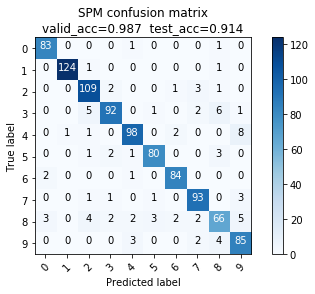

In [13]:
plot_confusion_matrix(confusion_m,classes=class_names,title='SPM confusion matrix\nvalid_acc='+str(accuracy_score(y_valid[0:1000],valid_predictions))+'  test_acc='+str(accuracy_score(y_test[0:1000],test_predictions)))